In [1]:
import os
import sys

from PIL import Image
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [2]:
from numba import cuda
import gc
import torch
import time
import cv2
import PIL.Image
import random
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import albumentations
import timm
from collections import OrderedDict
from warnings import filterwarnings
filterwarnings("ignore")
device = torch.device('cuda')
torch.no_grad()

from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
import seaborn as sns

In [19]:
# hyperparameters
from scipy import optimize

class args:
    batch_size = 128
    n_worker = 20

    image_size = 512
    #image_size = 640
    arch_name = 'tf_efficientnetv2_l_in21k'

    model_image_path = [
        './models_2class_2/fold_0/best_epoch9_ap0.8534853452608039.pth',
        './models_2class_2/fold_1/best_epoch6_ap0.8691063684343019.pth',
        './models_2class_2/fold_2/best_epoch4_ap0.8526443347470971.pth',
        './models_2class_2/fold_3/best_epoch9_ap0.8485065639200695.pth',
        './models_2class_2/fold_4/best_epoch9_ap0.8745943231121824.pth',
    ]

    model_study_path = [
        './models_2/fold_0/best_epoch5_ap0.5511132228812636.pth',
        './models_2/fold_1/best_epoch9_ap0.5633224707416896.pth',
        './models_2/fold_2/best_epoch9_ap0.5755307073313223.pth',
        './models_2/fold_3/best_epoch10_ap0.565790786617794.pth',
        './models_2/fold_4/best_epoch4_ap0.5755384751101597.pth',
    ]


    '''
    model_image_path = [
        '/kaggle/input/res640/image/best_fold0_epoch9_ap0.8647867925730408.pth',
        '/kaggle/input/res640/image/best_fold1_epoch7_ap0.8700921410992681.pth',
        '/kaggle/input/res640/image/best_fold2_epoch8_ap0.854623528545685.pth',
        '/kaggle/input/res640/image/best_fold3_epoch3_ap0.8503734797384243.pth',
        '/kaggle/input/res640/image/best_fold4_epoch7_ap0.8624137835356351.pth',
    ]

    model_study_path = [
        '/kaggle/input/res640/study/best_fold0_epoch10_ap0.5528757209205474.pth',
        '/kaggle/input/res640/study/best_fold1_epoch7_ap0.5591699074772426.pth',
        '/kaggle/input/res640/study/best_fold2_epoch5_ap0.588199354615613.pth',
        '/kaggle/input/res640/study/best_fold3_epoch10_ap0.5663838815142977.pth',
        '/kaggle/input/res640/study/best_fold4_epoch8_ap0.5778353583982486.pth',
    ]
    '''

    class_weight = [1,1,1,1,1,]

In [4]:
# 设置随机种子，以便实验复现

def set_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# 1. dcm to png

In [6]:
# from https://www.kaggle.com/code/xhlulu/siim-covid-19-convert-to-jpg-256px?scriptVersionId=63196459
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)

    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

In [7]:
def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    # Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
    im = Image.fromarray(array)
    
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    
    return im

In [8]:
image_id = []
dim0 = []
dim1 = []
splits = []
study_id = []

split = 'test'

save_dir = f'/kaggle/working/tmp/{split}/'

os.makedirs(save_dir, exist_ok=True)
    
for dirname, _, filenames in tqdm(os.walk(f'/kaggle/input/siim-covid19-detection/{split}')):
    for file in filenames:
        # set keep_ratio=True to have original aspect ratio
        xray = read_xray(os.path.join(dirname, file))
        im = resize(xray, size=512)  
        #im = resize(xray, size=640)
        im.save(os.path.join(save_dir, file.replace('dcm', 'png')))

        image_id.append(file.replace('.dcm', ''))
        dim0.append(xray.shape[0])
        dim1.append(xray.shape[1])
        splits.append(split)
        study_id.append(dirname.split('/')[-2])

0it [00:00, ?it/s]

In [9]:
meta = pd.DataFrame.from_dict({'image_id': image_id, 'dim0': dim0, 'dim1': dim1, 'split': splits, 'study_id':study_id})
meta = meta[meta['split'] == 'test']
meta['image_id'] = meta['image_id'] + '_image'
meta['study_id'] = meta['study_id'] + '_study'
meta.columns = ['id', 'dim0', 'dim1', 'split', 'study_id']
# meta.to_csv('meta_test.csv', index=False)
meta

,id,dim0,dim1,split,study_id
0,a29c5a68b07b_image,2320,2828,test,2fb11712bc93_study
1,9850b5470fd6_image,2330,2382,test,19c66935e737_study
2,8d6dea06a032_image,2422,3344,test,2fc50bf199cd_study
3,dfc5c09a50bc_image,1140,1387,test,97c5d6eb413d_study
4,7230234e120a_image,2318,2383,test,593c3f815635_study
...,...,...,...,...,...
1258,a43200bd5ceb_image,2336,2836,test,b12d2e5c39b7_study
1259,37bf83df1b86_image,3480,4240,test,6484393291ea_study
1260,b30d2aef985f_image,3480,4240,test,6484393291ea_study
1261,a37a362df0ac_image,3480,4240,test,531aa20ff7c3_study


In [5]:
all_df = pd.read_csv('./siim-covid19-detection/sample_submission.csv')
all_df['id_last_str'] = all_df["id"].str[-1]

study_len = all_df[all_df['id_last_str'] == 'y'].shape[0]

all_df

,id,PredictionString,id_last_str
0,00188a671292_study,negative 1 0 0 1 1,y
1,004bd59708be_study,negative 1 0 0 1 1,y
2,00508faccd39_study,negative 1 0 0 1 1,y
3,006486aa80b2_study,negative 1 0 0 1 1,y
4,00655178fdfc_study,negative 1 0 0 1 1,y
...,...,...,...
2472,46719b856de1_image,none 1 0 0 1 1,e
2473,31c07523a69a_image,none 1 0 0 1 1,e
2474,f77d7d1aebab_image,none 1 0 0 1 1,e
2475,ccc5b63ca96d_image,none 1 0 0 1 1,e


# 2. 2-class Predict on Image Level

In [6]:
split = 'test'

save_dir = f'./working/tmp/{split}/'

image_sub_df = pd.read_csv('./siim-covid19-detection/sample_submission.csv')
image_sub_df = image_sub_df[study_len:]

image_sub_df["file_name"] = image_sub_df["id"].str.replace('_image', '') + ".png"
label_cols = '2_class_prediction'
image_sub_df[label_cols] = 0
image_sub_df

,id,PredictionString,file_name,2_class_prediction
1214,557a70442928_image,none 1 0 0 1 1,557a70442928.png,0
1215,36141cda67ad_image,none 1 0 0 1 1,36141cda67ad.png,0
1216,2413a23a5477_image,none 1 0 0 1 1,2413a23a5477.png,0
1217,c263b1e9aa64_image,none 1 0 0 1 1,c263b1e9aa64.png,0
1218,4fe0444d7fc5_image,none 1 0 0 1 1,4fe0444d7fc5.png,0
...,...,...,...,...
2472,46719b856de1_image,none 1 0 0 1 1,46719b856de1.png,0
2473,31c07523a69a_image,none 1 0 0 1 1,31c07523a69a.png,0
2474,f77d7d1aebab_image,none 1 0 0 1 1,f77d7d1aebab.png,0
2475,ccc5b63ca96d_image,none 1 0 0 1 1,ccc5b63ca96d.png,0


## EfficientNet for 2-class Predict

In [7]:
import albumentations
from albumentations.pytorch import ToTensorV2
from albumentations import RandomCrop,HorizontalFlip,VerticalFlip,Rotate,RandomBrightnessContrast,\
    RandomResizedCrop,Normalize,Resize,Compose,GaussianBlur,RandomBrightness,RandomContrast,RandomGamma,RandomRotate90,Transpose,\
    ShiftScaleRotate,Blur,OpticalDistortion,GridDistortion,HueSaturationValue,IAAAdditiveGaussianNoise,IAAPerspective,RandomSizedCrop,\
    RandomShadow,RandomSnow,RandomRain,RandomFog,CenterCrop,CoarseDropout,ChannelShuffle,ToGray,Cutout,PadIfNeeded,RandomCrop,VerticalFlip,HorizontalFlip,\
    Transpose,RandomRotate90,ShiftScaleRotate,ElasticTransform,GridDistortion,OpticalDistortion,RandomSizedCrop,HueSaturationValue,RGBShift,RandomBrightnessContrast,\
    RandomGamma,CLAHE,Blur,MedianBlur,MotionBlur,GaussNoise,GaussianBlur,RGBShift,RandomBrightnessContrast,IAAEmboss,IAASharpen,IAASuperpixels,RandomFog,RandomRain,\
    RandomShadow,RandomSnow,RandomSunFlare

transform_test = albumentations.Compose([
    Resize(args.image_size,args.image_size),
    Normalize()],
)

In [8]:
import cv2
from PIL import Image
from torchvision.transforms import ToTensor,Normalize,Compose,Resize
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,df,transform=None,mode:str='test'):
        self.df = df
        self.transform = transform
        self.mode = mode
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        img = Image.open(f'./tmp_512/{split}/{row.file_name}').convert('RGB')
    
        img = self.transform(image=np.array(img))['image'].transpose(2,0,1)
        return img

In [9]:
from torch import adaptive_max_pool1d
from torch.utils.data import DataLoader
#effnetv2
import torch.nn as nn
import timm
from torch.nn import functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.nn import AvgPool2d,AdaptiveAvgPool2d


class Swish(nn.Module):
        def forward(self, x):
            return x * torch.sigmoid(x)
        
class Effnetv2(nn.Module):
    def __init__(self,pretrained=True):
        super().__init__()
        self.model = timm.create_model(args.arch_name, pretrained=pretrained ,num_classes=2, drop_rate = 0, drop_path_rate=0)
        self.logit = nn.Linear(self.model.classifier.in_features,2)
        self.preprocess = nn.Sequential(
            self.model.conv_stem,
            self.model.bn1,
            Swish()
        )
        self.blocks = self.model.blocks
        self.mask = nn.Sequential(
            nn.Conv2d(224, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=1, padding=0),
        )
        self.classifier = nn.Sequential(
             self.model.conv_head,
                self.model.bn2,
                Swish(),
        )

    def forward(self,x):
        batch_size = len(x)
        x = self.preprocess(x)
        for block in self.blocks[:5]:
            x = block(x)
        mask = self.mask(x)
        for block in self.blocks[5:]:
            x = block(x)
        x = self.classifier(x)
        x = AdaptiveAvgPool2d((1,1))(x)
        return self.logit(x.view(batch_size,-1)),mask

In [10]:
models_list = []

def load_study_model():
    for pth in args.model_image_path:
        model = Effnetv2(pretrained=False)
        print(pth)
        state = torch.load(pth, map_location='cuda:0') 
        model.load_state_dict(state)
        model.to(device);
        model.eval()
        models_list.append(model)
    print(len(models_list))

load_study_model()

./models_2class_2/fold_0/best_epoch9_ap0.8534853452608039.pth
./models_2class_2/fold_1/best_epoch6_ap0.8691063684343019.pth
./models_2class_2/fold_2/best_epoch4_ap0.8526443347470971.pth
./models_2class_2/fold_3/best_epoch9_ap0.8485065639200695.pth
./models_2class_2/fold_4/best_epoch9_ap0.8745943231121824.pth
5


In [11]:
from functools import lru_cache

def test_func(models_list, test_loader):
    all_logits = []
    with torch.no_grad():
        for images in tqdm(test_loader): 
            images = images.to(device).float() 
            avg_model_preds = []
            for model in models_list:
                model.eval()
                logits1, mask1 = model(images)  
                logits2, mask2 = model(images.flip(-1))
                logits = (logits1.sigmoid().to('cpu').numpy() + logits2.sigmoid().to('cpu').numpy()) / 2
                avg_model_preds.append(logits)
            avg_model_preds = np.average(avg_model_preds, axis=0, weights=args.class_weight) ####
            all_logits.append(avg_model_preds)
        all_logits = np.concatenate(all_logits)
        return all_logits

In [12]:
test_dataset = MyDataset(image_sub_df,transform = transform_test,mode = 'test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers = args.n_worker, drop_last=False, pin_memory=True)

image_sub_df[label_cols] = test_func(models_list,test_dataloader)
image_sub_df

  0%|          | 0/10 [00:00<?, ?it/s]

,id,PredictionString,file_name,2_class_prediction
1214,557a70442928_image,none 1 0 0 1 1,557a70442928.png,0.620744
1215,36141cda67ad_image,none 1 0 0 1 1,36141cda67ad.png,0.456655
1216,2413a23a5477_image,none 1 0 0 1 1,2413a23a5477.png,0.026519
1217,c263b1e9aa64_image,none 1 0 0 1 1,c263b1e9aa64.png,0.076255
1218,4fe0444d7fc5_image,none 1 0 0 1 1,4fe0444d7fc5.png,0.131527
...,...,...,...,...
2472,46719b856de1_image,none 1 0 0 1 1,46719b856de1.png,0.711076
2473,31c07523a69a_image,none 1 0 0 1 1,31c07523a69a.png,0.030371
2474,f77d7d1aebab_image,none 1 0 0 1 1,f77d7d1aebab.png,0.845651
2475,ccc5b63ca96d_image,none 1 0 0 1 1,ccc5b63ca96d.png,0.995424


In [16]:
cp_image_sub_df = image_sub_df.copy()

In [17]:
meta = pd.read_csv('./meta_512.csv')
meta.rename(columns={'image_id':'id'},inplace=True)
meta['id'] = meta['id'].apply(lambda x: x+"_image")
image_sub_df = image_sub_df.merge(meta,how="left",on='id')
image_sub_df["none"] = 1-image_sub_df[label_cols]
image_sub_df

,id,PredictionString,file_name,2_class_prediction,dim0_x,dim1_x,split_x,study_id_x,none,dim0_y,dim1_y,split_y,study_id_y
0,557a70442928_image,none 1 0 0 1 1,557a70442928.png,0.620744,3320,3408,test,795051254905,0.379256,3320,3408,test,795051254905
1,36141cda67ad_image,none 1 0 0 1 1,36141cda67ad.png,0.456655,3480,4240,test,0d476d070d71,0.543345,3480,4240,test,0d476d070d71
2,2413a23a5477_image,none 1 0 0 1 1,2413a23a5477.png,0.026519,2320,2832,test,4996bf5117c7,0.973481,2320,2832,test,4996bf5117c7
3,c263b1e9aa64_image,none 1 0 0 1 1,c263b1e9aa64.png,0.076255,2801,2802,test,8b273337a684,0.923745,2801,2802,test,8b273337a684
4,4fe0444d7fc5_image,none 1 0 0 1 1,4fe0444d7fc5.png,0.131527,2392,3014,test,aafc8126d5a1,0.868473,2392,3014,test,aafc8126d5a1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,46719b856de1_image,none 1 0 0 1 1,46719b856de1.png,0.711076,2648,2867,test,ee860264dd8c,0.288924,2648,2867,test,ee860264dd8c
1259,31c07523a69a_image,none 1 0 0 1 1,31c07523a69a.png,0.030371,3488,4256,test,81c860c6efe8,0.969629,3488,4256,test,81c860c6efe8
1260,f77d7d1aebab_image,none 1 0 0 1 1,f77d7d1aebab.png,0.845651,3052,3012,test,e6e02ec8aff5,0.154349,3052,3012,test,e6e02ec8aff5
1261,ccc5b63ca96d_image,none 1 0 0 1 1,ccc5b63ca96d.png,0.995424,2520,3032,test,b93bfa119338,0.004576,2520,3032,test,b93bfa119338


In [18]:
meta

,id,dim0,dim1,split,study_id
0,ab15692269fc_image,2800,3408,test,50a27d21b5c5
1,bc72a19f5d87_image,2800,2874,test,50a27d21b5c5
2,05435da60872_image,2320,2832,test,4dee79301687
3,7e3c0527ddb7_image,1958,1960,test,b2ef21c21a69
4,c5a76564ef83_image,3480,4240,test,1ebfe0b61513
...,...,...,...,...,...
7592,12c435a26db5_image,2800,3408,train,c553748e7049
7593,a06bc359b5fb_image,2800,3408,train,551ce2f497af
7594,4ed22347ea95_image,3480,4248,train,90857afa360f
7595,f071f42fe94e_image,3198,3056,train,4f4a405729f2


In [19]:
del models_list
torch.cuda.empty_cache()
gc.collect()

79

## Yolo Predict

In [20]:
yolo_df = all_df[study_len:].reset_index(drop=True)
yolo_df = pd.merge(yolo_df, meta, on='id', how='left')
yolo_df = yolo_df.drop(['PredictionString'], axis=1)
yolo_df

,id,id_last_str,dim0,dim1,split,study_id
0,557a70442928_image,e,3320,3408,test,795051254905
1,36141cda67ad_image,e,3480,4240,test,0d476d070d71
2,2413a23a5477_image,e,2320,2832,test,4996bf5117c7
3,c263b1e9aa64_image,e,2801,2802,test,8b273337a684
4,4fe0444d7fc5_image,e,2392,3014,test,aafc8126d5a1
...,...,...,...,...,...,...
1258,46719b856de1_image,e,2648,2867,test,ee860264dd8c
1259,31c07523a69a_image,e,3488,4256,test,81c860c6efe8
1260,f77d7d1aebab_image,e,3052,3012,test,e6e02ec8aff5
1261,ccc5b63ca96d_image,e,2520,3032,test,b93bfa119338


In [21]:
'''
import torch

if not os.path.exists('/kaggle/working/yolov5'):
    shutil.copytree('/kaggle/input/yolov5-repo/yolov5-master', '/kaggle/working/yolov5')
os.chdir('/kaggle/working/yolov5')

weights_dir = '/kaggle/working/yolov5/best.pt'
test_dir = f'/kaggle/working/tmp/{split}'

!python detect.py --weights $weights_dir\
--img 512\
--augment\
--conf 0.001\
--iou 0.5\
--source $test_dir\
--name test\
--save-txt --save-conf --exist-ok
'''

from ultralytics import YOLO
from PIL import Image
import cv2

model = YOLO("./siim-covid19-detection/YOLOv8_512_fold0_200/weights/best.pt")
#model = YOLO("/kaggle/input/res640/yolov8.pt")
model.predict(source=f'./tmp_512/{split}', imgsz=args.batch_size, augment=True, conf=0.001, iou=0.5, save_txt=True, save_conf=True, show=False,batch = 64)
#model.predict(source=f'/kaggle/working/tmp/{split}', imgsz=640, augment=True, conf=0.001, iou=0.5, save_txt=True, save_conf=True, show=False)



    WARNING ⚠️ stream/video/webcam/dir predict source will accumulate results in RAM unless `stream=True` is passed,
    causing potential out-of-memory errors for large sources or long-running streams/videos.

    Usage:
        results = model(source=..., stream=True)  # generator of Results objects
        for r in results:
            boxes = r.boxes  # Boxes object for bbox outputs
            masks = r.masks  # Masks object for segment masks outputs
            probs = r.probs  # Class probabilities for classification outputs

image 1/1263 /home/outerform/github-repo/DeepLearningCourse-Project/tmp_512/test/0026720152f5.png: 128x128 17 opacitys, 24.4ms
image 2/1263 /home/outerform/github-repo/DeepLearningCourse-Project/tmp_512/test/00fc8fc35dc1.png: 128x128 8 opacitys, 24.9ms
image 3/1263 /home/outerform/github-repo/DeepLearningCourse-Project/tmp_512/test/01c3512eebc3.png: 128x128 12 opacitys, 24.8ms
image 4/1263 /home/outerform/github-repo/DeepLearningCourse-Project/tmp_512/tes

[ultralytics.yolo.engine.results.Results object with attributes:
 
 boxes: ultralytics.yolo.engine.results.Boxes object
 keypoints: None
 keys: ['boxes']
 masks: None
 names: {0: 'none', 1: 'opacity'}
 orig_img: array([[[ 73,  73,  73],
         [ 64,  64,  64],
         [ 59,  59,  59],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[ 84,  84,  84],
         [ 69,  69,  69],
         [ 54,  54,  54],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[ 81,  81,  81],
         [ 59,  59,  59],
         [ 39,  39,  39],
         ...,
         [  1,   1,   1],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        ...,
 
        [[197, 197, 197],
         [172, 172, 172],
         [161, 161, 161],
         ...,
         [ 94,  94,  94],
         [ 87,  87,  87],
         [ 70,  70,  70]],
 
        [[200, 200, 200],
         [170, 170, 170],
         [151, 151, 151],
    

In [22]:
def yolo2voc(bboxes):
    bboxes = bboxes.copy().astype(float)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    return bboxes

def yolo2voc1(image_height, image_width, bboxes):
    bboxes = bboxes.copy().astype(float)
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    return bboxes

In [23]:
from ensemble_boxes import weighted_boxes_fusion
image_ids = []
PredictionStrings = []

for i in range(len(yolo_df)):
    boxes_list = []
    scores_list = []
    labels_list = []
    is_exist = True
    
    iou_thr = 0.5
    skip_box_thr = 0.0001
    image_id = yolo_df.loc[i,'id']
    w, h = yolo_df.loc[yolo_df.id==image_id,['dim1', 'dim0']].values[0]
        
    #file_path = '/kaggle/working/yolov5/runs/detect/test/labels/{}.txt'.format(image_id.replace('_image', ''))
    file_path = './runs/detect/predict/labels/{}.txt'.format(image_id.replace('_image', ''))
    if os.path.exists(file_path):
        f = open(file_path, 'r')
        data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
        data = data[:, [0, 5, 1, 2, 3, 4]]
        data[:,2:] = yolo2voc(data[:, 2:])
    else:
        is_exist = False
        
    if is_exist==False:
        continue

    bboxes = list(np.round(np.concatenate((data[:, :2], np.round(yolo2voc1(h, w, data[:, 2:]))), axis =1).reshape(-1), 12).astype(str))
    for idx in range(len(bboxes)):
        bboxes[idx] = str(int(float(bboxes[idx]))) if idx%6!=1 else bboxes[idx]
    image_ids.append(image_id)
    PredictionStrings.append(' '.join(bboxes))

yolo_predict_df = pd.DataFrame({'id':image_ids, 'PredictionString':PredictionStrings})
yolo_predict_df

,id,PredictionString
0,557a70442928_image,1 0.106421001256 1369 1937 3323 3320 1 0.06746...
1,36141cda67ad_image,1 0.021395500749 953 18 4204 3271 1 0.01740260...
2,2413a23a5477_image,1 0.205156996846 402 6 2674 1821 1 0.134203001...
3,c263b1e9aa64_image,1 0.134487003088 145 81 2621 2216 1 0.08156090...
4,4fe0444d7fc5_image,1 0.153991997242 165 23 3014 1858 1 0.11115200...
...,...,...
1222,46719b856de1_image,1 0.082592397928 877 449 2400 2028 1 0.0523868...
1223,31c07523a69a_image,1 0.412521988153 782 180 4256 3131 1 0.3151269...
1224,f77d7d1aebab_image,1 0.052264500409 0 19 3012 2823 1 0.0299821998...
1225,ccc5b63ca96d_image,1 0.001255730051 19 0 2987 2511


In [24]:
yolo_df = pd.merge(yolo_df, yolo_predict_df, on = 'id', how = 'left').fillna("none 1 0 0 1 1")
yolo_df = yolo_df[['id', 'PredictionString']]
yolo_df

,id,PredictionString
0,557a70442928_image,1 0.106421001256 1369 1937 3323 3320 1 0.06746...
1,36141cda67ad_image,1 0.021395500749 953 18 4204 3271 1 0.01740260...
2,2413a23a5477_image,1 0.205156996846 402 6 2674 1821 1 0.134203001...
3,c263b1e9aa64_image,1 0.134487003088 145 81 2621 2216 1 0.08156090...
4,4fe0444d7fc5_image,1 0.153991997242 165 23 3014 1858 1 0.11115200...
...,...,...
1258,46719b856de1_image,1 0.082592397928 877 449 2400 2028 1 0.0523868...
1259,31c07523a69a_image,1 0.412521988153 782 180 4256 3131 1 0.3151269...
1260,f77d7d1aebab_image,1 0.052264500409 0 19 3012 2823 1 0.0299821998...
1261,ccc5b63ca96d_image,1 0.001255730051 19 0 2987 2511


In [25]:
for i in range(yolo_df.shape[0]):
    if yolo_df.loc[i,'PredictionString'] == "none 1 0 0 1 1":
        continue
    sub_df_split = yolo_df.loc[i,'PredictionString'].split()
    sub_df_list = []
    for j in range(int(len(sub_df_split) / 6)):
        sub_df_list.append('opacity')
        sub_df_list.append(sub_df_split[6 * j + 1])
        sub_df_list.append(sub_df_split[6 * j + 2])
        sub_df_list.append(sub_df_split[6 * j + 3])
        sub_df_list.append(sub_df_split[6 * j + 4])
        sub_df_list.append(sub_df_split[6 * j + 5])
    yolo_df.loc[i,'PredictionString'] = ' '.join(sub_df_list)

yolo_df['none'] = image_sub_df['none'] 
for i in range(yolo_df.shape[0]):
    if yolo_df.loc[i,'PredictionString'] != 'none 1 0 0 1 1':
        yolo_df.loc[i,'PredictionString'] = yolo_df.loc[i,'PredictionString'] + ' none ' + str(yolo_df.loc[i,'none']) + ' 0 0 1 1'

yolo_df = yolo_df[['id', 'PredictionString']] 
# yolo_df.to_csv('yolo_df.csv', index=False)
image_df = yolo_df
image_df

,id,PredictionString
0,557a70442928_image,opacity 0.106421001256 1369 1937 3323 3320 opa...
1,36141cda67ad_image,opacity 0.021395500749 953 18 4204 3271 opacit...
2,2413a23a5477_image,opacity 0.205156996846 402 6 2674 1821 opacity...
3,c263b1e9aa64_image,opacity 0.134487003088 145 81 2621 2216 opacit...
4,4fe0444d7fc5_image,opacity 0.153991997242 165 23 3014 1858 opacit...
...,...,...
1258,46719b856de1_image,opacity 0.082592397928 877 449 2400 2028 opaci...
1259,31c07523a69a_image,opacity 0.412521988153 782 180 4256 3131 opaci...
1260,f77d7d1aebab_image,opacity 0.052264500409 0 19 3012 2823 opacity ...
1261,ccc5b63ca96d_image,opacity 0.001255730051 19 0 2987 2511 none 0.0...


# 3. 4-class Predict on Study Level

In [26]:
study_df = pd.read_csv('./siim-covid19-detection/sample_submission.csv')
study_df = study_df[:study_len]
study_df

,id,PredictionString
0,00188a671292_study,negative 1 0 0 1 1
1,004bd59708be_study,negative 1 0 0 1 1
2,00508faccd39_study,negative 1 0 0 1 1
3,006486aa80b2_study,negative 1 0 0 1 1
4,00655178fdfc_study,negative 1 0 0 1 1
...,...,...
1209,ff1ba0e9aaf0_study,negative 1 0 0 1 1
1210,ff2cc4de58c5_study,negative 1 0 0 1 1
1211,ff2f0a744930_study,negative 1 0 0 1 1
1212,ff88940dce8b_study,negative 1 0 0 1 1


In [37]:

meta_study = meta.drop_duplicates(['study_id'], keep='last')
meta_study.columns = ['image_id', 'dim0', 'dim1', 'split', 'id']
meta_study['id'] = meta_study['id'].apply(lambda x: x+'_study')

In [38]:
meta_study = meta_study.loc[meta_study['split'] == 'test']

In [39]:
meta_study

,image_id,dim0,dim1,split,id
1,bc72a19f5d87_image,2800,2874,test,50a27d21b5c5_study
2,05435da60872_image,2320,2832,test,4dee79301687_study
3,7e3c0527ddb7_image,1958,1960,test,b2ef21c21a69_study
4,c5a76564ef83_image,3480,4240,test,1ebfe0b61513_study
5,39f8e38c9d43_image,2320,2832,test,23847f6a41a6_study
...,...,...,...,...,...
1256,3b4e41cb8212_image,2536,3048,test,1c57d288256c_study
1259,ea9ee4d59c59_image,1760,2140,test,bc73883551cf_study
1260,7e2e014e1656_image,2539,3050,test,fdad33449860_study
1261,d8b8ef2bcbf6_image,2180,2660,test,2e3ae25addcc_study


In [41]:
study_df = pd.read_csv('./siim-covid19-detection/sample_submission.csv')
study_df = study_df[:study_len]

study_df = pd.merge(study_df, meta_study, on='id', how='left')

study_df['file_name'] = study_df['image_id'].str.replace('_image', '') + ".png"
study_df = study_df[['id', 'PredictionString', 'file_name']]

study_df['negative'] = 0
study_df['typical'] = 0
study_df['indeterminate'] = 0
study_df['atypical'] = 0

label_cols = study_df.columns[3:]

study_df

,id,PredictionString,file_name,negative,typical,indeterminate,atypical
0,00188a671292_study,negative 1 0 0 1 1,3dcdfc352a06.png,0,0,0,0
1,004bd59708be_study,negative 1 0 0 1 1,c39146cbda47.png,0,0,0,0
2,00508faccd39_study,negative 1 0 0 1 1,951211f8e1bb.png,0,0,0,0
3,006486aa80b2_study,negative 1 0 0 1 1,5e0e7acd9c7d.png,0,0,0,0
4,00655178fdfc_study,negative 1 0 0 1 1,5b8ee5baa1d5.png,0,0,0,0
...,...,...,...,...,...,...,...
1209,ff1ba0e9aaf0_study,negative 1 0 0 1 1,064b37b01cd2.png,0,0,0,0
1210,ff2cc4de58c5_study,negative 1 0 0 1 1,02eceb0fc405.png,0,0,0,0
1211,ff2f0a744930_study,negative 1 0 0 1 1,16a0d37747d7.png,0,0,0,0
1212,ff88940dce8b_study,negative 1 0 0 1 1,aa55fc6c616c.png,0,0,0,0


In [42]:
import albumentations
from albumentations.pytorch import ToTensorV2
from albumentations import RandomCrop,HorizontalFlip,VerticalFlip,Rotate,RandomBrightnessContrast,\
    RandomResizedCrop,Normalize,Resize,Compose,GaussianBlur,RandomBrightness,RandomContrast,RandomGamma,RandomRotate90,Transpose,\
    ShiftScaleRotate,Blur,OpticalDistortion,GridDistortion,HueSaturationValue,IAAAdditiveGaussianNoise,IAAPerspective,RandomSizedCrop,\
    RandomShadow,RandomSnow,RandomRain,RandomFog,CenterCrop,CoarseDropout,ChannelShuffle,ToGray,Cutout,PadIfNeeded,RandomCrop,VerticalFlip,HorizontalFlip,\
    Transpose,RandomRotate90,ShiftScaleRotate,ElasticTransform,GridDistortion,OpticalDistortion,RandomSizedCrop,HueSaturationValue,RGBShift,RandomBrightnessContrast,\
    RandomGamma,CLAHE,Blur,MedianBlur,MotionBlur,GaussNoise,GaussianBlur,RGBShift,RandomBrightnessContrast,IAAEmboss,IAASharpen,IAASuperpixels,RandomFog,RandomRain,\
    RandomShadow,RandomSnow,RandomSunFlare

transform_test = albumentations.Compose([
    Resize(args.image_size,args.image_size),
    Normalize()],
)

In [48]:
import cv2
from PIL import Image
from torchvision.transforms import ToTensor,Normalize,Compose,Resize
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,df,transform=None,mode:str='test'):
        self.df = df
        self.transform = transform
        self.mode = mode
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        img = Image.open(f'./tmp_512/{split}/{row.file_name}').convert('RGB')
    
        img = self.transform(image=np.array(img))['image'].transpose(2,0,1)
        return img

In [49]:
from torch import adaptive_max_pool1d
from torch.utils.data import DataLoader
#effnetv2
import torch.nn as nn
import timm
from torch.nn import functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.nn import AvgPool2d,AdaptiveAvgPool2d


class Swish(nn.Module):
        def forward(self, x):
            return x * torch.sigmoid(x)
        
class Effnetv2(nn.Module):
    def __init__(self,pretrained=True):
        super().__init__()
        self.model = timm.create_model(args.arch_name,pretrained=pretrained,num_classes=4,drop_rate = 0,drop_path_rate=0)
        self.logit = nn.Linear(self.model.classifier.in_features,4)
        self.preprocess = nn.Sequential(
            self.model.conv_stem,
            self.model.bn1,
            Swish()
        )
        self.blocks = self.model.blocks
        self.mask = nn.Sequential(
            nn.Conv2d(224, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=1, padding=0),
        )
        self.classifier = nn.Sequential(
             self.model.conv_head,
                self.model.bn2,
                Swish(),
        )

    def forward(self,x):
        batch_size = len(x)
        x = self.preprocess(x)
        for block in self.blocks[:5]:
            x = block(x)
        mask = self.mask(x)
        for block in self.blocks[5:]:
            x = block(x)
        x = self.classifier(x)
        x = AdaptiveAvgPool2d((1,1))(x)
        return self.logit(x.view(batch_size,-1)),mask

In [50]:
models_list = []

def load_study_model():
    for pth in args.model_study_path:
        model = Effnetv2(pretrained=False)
        print(pth)
        state = torch.load(pth, map_location='cuda:0') 
        model.load_state_dict(state)
        model.to(device);
        model.eval()
        models_list.append(model)
    print(len(models_list))
    
load_study_model()

./models_2/fold_0/best_epoch5_ap0.5511132228812636.pth
./models_2/fold_1/best_epoch9_ap0.5633224707416896.pth
./models_2/fold_2/best_epoch9_ap0.5755307073313223.pth
./models_2/fold_3/best_epoch10_ap0.565790786617794.pth
./models_2/fold_4/best_epoch4_ap0.5755384751101597.pth
5


In [51]:
def test_func(models_list, test_loader):
    all_logits = []
    with torch.no_grad():
        for images in tqdm(test_loader): 
            images = images.to(device).float() 
            avg_model_preds = []
            for model in models_list:
                model.eval()
                logits1, mask1 = model(images)  
                logits2, mask2 = model(images.flip(-1))
                logits = (logits1.sigmoid().to('cpu').numpy() + logits2.sigmoid().to('cpu').numpy()) / 2
                avg_model_preds.append(logits)
            avg_model_preds = np.average(avg_model_preds, axis=0, weights=args.class_weight) ####
            all_logits.append(avg_model_preds)
        all_logits = np.concatenate(all_logits)
        return all_logits

In [52]:
test_dataset = MyDataset(study_df,transform = transform_test,mode = 'test')

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers = args.n_worker, drop_last=False, pin_memory=True)

study_df[label_cols] = test_func(models_list,test_dataloader)
study_df = study_df.drop("file_name",axis=1)
study_df.columns = ['id', 'PredictionString1', 'negative', 'typical', 'indeterminate', 'atypical']
all_df = pd.merge(all_df, study_df, on = 'id', how = 'left')
all_df

  0%|          | 0/10 [00:00<?, ?it/s]

,id,PredictionString,id_last_str,PredictionString1,negative,typical,indeterminate,atypical
0,00188a671292_study,negative 1 0 0 1 1,y,negative 1 0 0 1 1,0.830564,0.057761,0.100142,0.029530
1,004bd59708be_study,negative 1 0 0 1 1,y,negative 1 0 0 1 1,0.002715,0.871463,0.079366,0.021141
2,00508faccd39_study,negative 1 0 0 1 1,y,negative 1 0 0 1 1,0.646568,0.089408,0.162787,0.107968
3,006486aa80b2_study,negative 1 0 0 1 1,y,negative 1 0 0 1 1,0.423138,0.201357,0.299610,0.079216
4,00655178fdfc_study,negative 1 0 0 1 1,y,negative 1 0 0 1 1,0.438843,0.240196,0.251906,0.057082
...,...,...,...,...,...,...,...,...
2472,46719b856de1_image,none 1 0 0 1 1,e,NaN,NaN,NaN,NaN,NaN
2473,31c07523a69a_image,none 1 0 0 1 1,e,NaN,NaN,NaN,NaN,NaN
2474,f77d7d1aebab_image,none 1 0 0 1 1,e,NaN,NaN,NaN,NaN,NaN
2475,ccc5b63ca96d_image,none 1 0 0 1 1,e,NaN,NaN,NaN,NaN,NaN


In [53]:
for i in range(study_len):
    negative = all_df.loc[i,'negative']
    typical = all_df.loc[i,'typical']
    indeterminate = all_df.loc[i,'indeterminate']
    atypical = all_df.loc[i,'atypical']
    all_df.loc[i, 'PredictionString'] = f'negative {negative} 0 0 1 1 typical {typical} 0 0 1 1 indeterminate {indeterminate} 0 0 1 1 atypical {atypical} 0 0 1 1'
    
study_df = all_df[['id', 'PredictionString']][:study_len]
# study_df.to_csv('study_df.csv', index=False)
study_df

,id,PredictionString
0,00188a671292_study,negative 0.8305639505386353 0 0 1 1 typical 0....
1,004bd59708be_study,negative 0.002715232386071875 0 0 1 1 typical ...
2,00508faccd39_study,negative 0.6465677618980408 0 0 1 1 typical 0....
3,006486aa80b2_study,negative 0.4231379270553589 0 0 1 1 typical 0....
4,00655178fdfc_study,negative 0.4388429671525955 0 0 1 1 typical 0....
...,...,...
1209,ff1ba0e9aaf0_study,negative 0.26602246016263964 0 0 1 1 typical 0...
1210,ff2cc4de58c5_study,negative 0.09476226717233657 0 0 1 1 typical 0...
1211,ff2f0a744930_study,negative 0.000815855324617587 0 0 1 1 typical ...
1212,ff88940dce8b_study,negative 0.6192761540412903 0 0 1 1 typical 0....


In [54]:
del models_list
torch.cuda.empty_cache()
gc.collect()

50

# 4. Merge Study and Image

In [118]:
image_df = meta.merge(yolo_df,on="id")
image_df

,id,dim0,dim1,split,study_id,PredictionString
0,ab15692269fc_image,2800,3408,test,50a27d21b5c5,opacity 0.012023000047 52 1899 1378 2800 opaci...
1,bc72a19f5d87_image,2800,2874,test,50a27d21b5c5,opacity 0.090172201395 134 5 2632 2626 opacity...
2,05435da60872_image,2320,2832,test,4dee79301687,opacity 0.22855399549 153 107 2321 1981 opacit...
3,7e3c0527ddb7_image,1958,1960,test,b2ef21c21a69,opacity 0.425637990236 65 250 963 1698 opacity...
4,c5a76564ef83_image,3480,4240,test,1ebfe0b61513,opacity 0.010264200158 530 1470 1879 2486 opac...
...,...,...,...,...,...,...
1258,9d0f2c2645da_image,1760,2140,test,bc73883551cf,opacity 0.154529005289 568 54 2004 1439 opacit...
1259,ea9ee4d59c59_image,1760,2140,test,bc73883551cf,opacity 0.154529005289 568 54 2004 1439 opacit...
1260,7e2e014e1656_image,2539,3050,test,fdad33449860,opacity 0.123604997993 856 24 2942 1870 opacit...
1261,d8b8ef2bcbf6_image,2180,2660,test,2e3ae25addcc,opacity 0.083495400846 164 4 2571 1762 opacity...


In [137]:
from ensemble_boxes import *

weights = [3, 1]
iou_thr = 0.4
skip_box_thr = 0.0001
image_output_list = []

for index, id_, dim0, dim1, split, study_id, yolo5_boxes in image_df.itertuples():
    yolo5_boxes_list = yolo5_boxes.split(" ")
    assert len(yolo5_boxes_list) % 6 == 0
    none_list = yolo5_boxes_list[-6:]
    yolo5_boxes_list = yolo5_boxes_list[:-6]
    boxes_list = [[],[]]
    scores_list = [[],[]]
    for i in range(len(yolo5_boxes_list)):
        if i % 6 == 1:
            scores_list[0].append(float(yolo5_boxes_list[i]))
        if i % 6 == 2:
            boxes_list[0].append([float(yolo5_boxes_list[i])/dim1,
                                  float(yolo5_boxes_list[i+1])/dim0,
                                  float(yolo5_boxes_list[i+2])/dim1,
                                  float(yolo5_boxes_list[i+3])/dim0])

            
    labels_list = [[0]*len(scores_list[0]), [0]*len(scores_list[1])]        
    boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    
    output_str = ""
    for box, score in zip(boxes, scores): 
        output_str += "opacity "
        output_str += f"{score} "
        for b_i in range(4):
            if b_i in [0,2]:
                output_str += f"{int(round(box[b_i]*dim1,0))} "
            elif b_i in [1,3]:
                output_str += f"{int(round(box[b_i]*dim0,0))} "

    output_str += " ".join(none_list)
    image_output_list.append(output_str)

    
image_df["PredictionString"] = image_output_list
image_df = image_df[["id", "PredictionString"]]
image_df

ValueError: not enough values to unpack (expected 7, got 3)

In [138]:
submission_df = study_df.append(image_df).reset_index(drop=True)
os.makedirs('./working', exist_ok=True)
submission_df.to_csv('./working/submission.csv',index = False)
submission_df

,id,PredictionString
0,00188a671292_study,negative 0.8305639505386353 0 0 1 1 typical 0....
1,004bd59708be_study,negative 0.002715232386071875 0 0 1 1 typical ...
2,00508faccd39_study,negative 0.6465677618980408 0 0 1 1 typical 0....
3,006486aa80b2_study,negative 0.4231379270553589 0 0 1 1 typical 0....
4,00655178fdfc_study,negative 0.4388429671525955 0 0 1 1 typical 0....
...,...,...
2472,9d0f2c2645da_image,opacity 0.11589675396674999 568 54 2004 1439 o...
2473,ea9ee4d59c59_image,opacity 0.11589675396674999 568 54 2004 1439 o...
2474,7e2e014e1656_image,opacity 0.09270374849475 856 24 2942 1870 opac...
2475,d8b8ef2bcbf6_image,opacity 0.0626215506345 164 4 2571 1762 opacit...


In [5]:
import pandas as pd
submission_df = pd.read_csv('./working/submission.csv')

In [13]:
meta = pd.read_csv('./working/meta.csv')
meta

,id,dim0,dim1,split
0,3dcdfc352a06_image,3480,4248,test
1,c39146cbda47_image,3488,4256,test
2,951211f8e1bb_image,2320,2832,test
3,5e0e7acd9c7d_image,2800,3408,test
4,5b8ee5baa1d5_image,2320,2832,test
...,...,...,...,...
1258,064b37b01cd2_image,3480,4240,test
1259,02eceb0fc405_image,3488,4256,test
1260,16a0d37747d7_image,3520,4280,test
1261,aa55fc6c616c_image,3001,3001,test


In [14]:
# shutil.rmtree('/kaggle/working/yolov5')
# shutil.rmtree('/kaggle/working/runs')

In [45]:
def scale(row,bboxes):
    scalex = args.image_size/row.dim1
    scaley =  args.image_size/row.dim0
    scaled_bboxes = np.zeros_like(bboxes)
    scaled_bboxes[:,[0,2]] = bboxes[:,[0,2]]*scalex
    scaled_bboxes[:,[1,3]] = bboxes[:,[1,3]]*scaley
    return scaled_bboxes


def get_bbox(row,th = 0.5):
    bboxes = []
    bbox = []
    labels  = row.PredictionString.split(' ')
    bboxes = []
    scores = []
    for i in range(0,len(labels), 6):
        # print(labels[i+2:i+6])
        if labels[i] !='none' and float(labels[i+1])>th:
            bboxes.append(list(map(float,labels[i+2:i+6])))
            scores.append(float(labels[i+1]))
    return scores,np.array(bboxes)


In [46]:
#draw boxes on image with PIL
def draw_bboxes(row, scores,bboxes):
    # img = cv2.imread(os.path.join('tmp/test',row.id.replace('_image','')+'.png'))
    # for bbox in bboxes:
    #     img = cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 3)
    # plt.imshow(img)
    # return img
    img = cv2.imread(os.path.join('tmp_512/test',row.id.replace('_image','')+'.png'))
    for score,bbox in zip(scores,bboxes):
        img = cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), 0x66ccff, 3)
        cv2.putText(img, f'{score:.2f}', (int(bbox[0])+20, int(bbox[1])+20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0x66, 0xcc, 255), 2, cv2.LINE_AA)
    plt.imshow(img)
    return img

opacity 0.08620724827051163 381 634 2951 2761 opacity 0.03225270006825 546 890 1594 2577 opacity 0.014798775315000002 255 420 1859 2628 opacity 0.0143896504305 598 1623 1500 2540 opacity 0.013308375142500002 305 1666 3124 2985 opacity 0.004686449887499999 1856 1858 3056 2655 opacity 0.0029147249295 230 59 1930 1262 opacity 0.001859624928 62 35 1864 611 opacity 0.0012888000345 2021 565 2919 1035 opacity 0.0011881950195 202 1409 1475 2768 opacity 0.0011602349985000001 1969 1691 3665 3470 opacity 0.000924555003 2465 2925 3751 3466 opacity 0.0009142499767499999 1493 1918 3190 3069 opacity 0.0008956274835 1308 1464 3035 2631 opacity 0.00083082000525 340 1743 1752 2994 opacity 0.0008160675060000001 754 1995 3328 3425 opacity 0.00078318748275 1953 365 3258 1098 opacity 0.00075936000225 3903 1420 4240 2577 none 0.9138843961060047 0 0 1 1
[[ 381.  634. 2951. 2761.]]
[[ 46.00754717  93.27816092 356.34716981 406.21609195]]


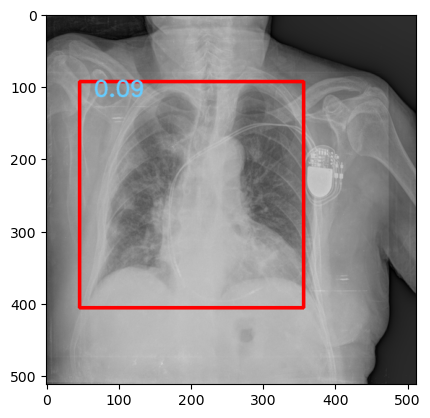

In [59]:
from matplotlib.pyplot import sca
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
res = pd.read_csv('./working/submission.csv')
#filter the id end with images
res = res.loc[res['id'].str.contains('image')]
res = res.reset_index()
res = res.merge(meta,on='id',how='left')

row = res.loc[101]
print(row.PredictionString)
scores,bboxes = get_bbox(row,th=0.05)
print(bboxes)
scaled_bboxes = scale(row,bboxes)
print(scaled_bboxes)
img = draw_bboxes(row, scores, scaled_bboxes)
# break
plt.savefig('t4.png')


In [153]:
row

index                                                            1219
id                                                 39f8e38c9d43_image
PredictionString    opacity 0.08629875071325 242 54 2555 2218 opac...
dim0                                                             2320
dim1                                                             2832
split                                                            test
study_id                                                 23847f6a41a6
Name: 5, dtype: object

In [125]:
image_df

,id,PredictionString
0,ab15692269fc_image,opacity 0.00901725003525 52 1899 1378 2800 opa...
1,bc72a19f5d87_image,opacity 0.06762915104625 134 5 2632 2626 opaci...
2,05435da60872_image,opacity 0.1714154966175 153 107 2321 1981 opac...
3,7e3c0527ddb7_image,opacity 0.31922849267700004 65 250 963 1698 op...
4,c5a76564ef83_image,opacity 0.0076981501185 530 1470 1879 2486 opa...
...,...,...
1258,9d0f2c2645da_image,opacity 0.11589675396674999 568 54 2004 1439 o...
1259,ea9ee4d59c59_image,opacity 0.11589675396674999 568 54 2004 1439 o...
1260,7e2e014e1656_image,opacity 0.09270374849475 856 24 2942 1870 opac...
1261,d8b8ef2bcbf6_image,opacity 0.0626215506345 164 4 2571 1762 opacit...
